In [1]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np

from bm_tools.data import Data
from bm_tools.plots import Plots
from bm_tools.stats import Stats

import matplotlib.pyplot as plt

# get data
data_obj = Data()
data_obj.add_anndata(pd.read_pickle("./../rna_prot_dataset.pkl"))
data_obj.add_metadata(pd.read_pickle("./../rna_prot_sample_metadata.pkl"), 0)
data_obj.add_metadata(pd.read_pickle("./../rna_prot_feature_metadata.pkl"), 1)


### [F09] U-Plot of correlation coefficients between proteomics and transcriptomics + correlation significance 

'U-Plot': Volcanoplot of protein-transcriptome correlation coefficient for each protein. Adjusted p-value is preferred. 

In [2]:
marker_ids = pd.read_csv("./marker_ids.csv", header = None, sep = "\t", names = ["gene", "id"])
gene_to_id = {k : v for k, v in zip(marker_ids['gene'], marker_ids['id'])}
id_to_gene = {k : v for k, v in zip(marker_ids['id'], marker_ids['gene'])}

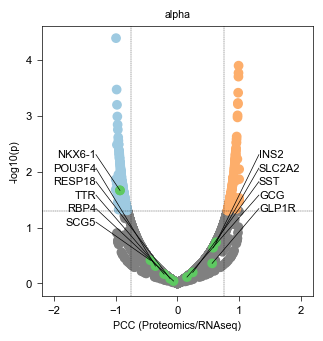

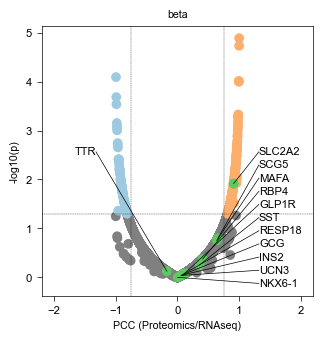

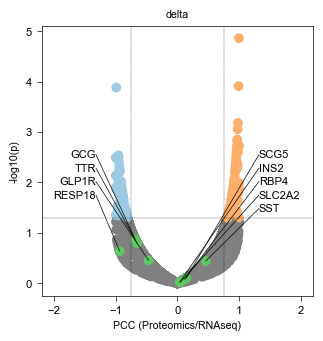

In [3]:
# this has to be done per cell type!!!
for ct in ['alpha', 'beta', 'delta']:

    # filter data for 100 % complete proteins
    data_obj_hm = data_obj.copy()
    data_obj_hm.filter_by_metadata({'sample' : [ct]}, axis = 0)
    data_obj_hm.filter_data_completeness(0.3)

    # split data: proteomics
    data_obj_p = data_obj_hm.copy()
    data_obj_p.filter_by_metadata({'readout' : ['proteomics']}, axis = 0)
    df_p = data_obj_p.get_data()
    df_p.index = df_p.index.str.replace("_proteomics", "")

    # split data: transcriptomics
    data_obj_t = data_obj_hm.copy()
    data_obj_t.filter_by_metadata({'readout' : ['transcriptomics']}, axis = 0)
    df_t = data_obj_t.get_data()
    df_t.index = df_t.index.str.replace("_transcriptomics", "")

    # compute pairwise correlations: each protein's transcriptomics vs proteomics profile
    pairwise_correlation_df = Stats.pairwise_correlation(
        data_a = df_p,
        data_b = df_t,
    )

    # add protein labels
    pairwise_correlation_df['protein'] = pairwise_correlation_df.index
    pairwise_correlation_df['gene'] = pairwise_correlation_df['protein'].map(id_to_gene, na_action = 'ignore')

    # Add gene names

    # visualize in scatterplot
    p = Plots()
    f, a, _ = p.new_volcano(
        data = pairwise_correlation_df,
        x_col = 'r',
        y_col = 'p',
        neg_log10_y = True,
        selected_labels = list(marker_ids['id'].values),
        label_display_col = 'gene',
        label_lookup_col = 'protein',
        lim_lower = -0.75,
        lim_upper = 0.75,
        y_threshold = -np.log10(0.05),
        max_labels = 0,
        title = ct,
        xlabel = "PCC (Proteomics/RNAseq)",
        ylabel = f"-log10(p)",
        dodge_labels = 'sides',
        left_right_label_kwargs = {
            'y_spacing_factor' : 1,
            'xlim_padding_factor' : 0.5,
            'highest_label_y_fraction' : 0.5,
        },
    )

    # save plot
    p.save_figure(
        fig = f,
        filename = f"figure_09_protein_protein_corr_volcano_{ct}_new.svg",
        output_dir = "./assets/20250423_revision_figures/",
        dpi = 300,
        nature_width = "single",
        nature_height = "single",
    )
